In [1]:
from IPython.display import HTML 
s="""<h1>Leapfrog, Lax-Friedrichs and Lax-Wendroff Schemes (Heaviside Input)</h1></br><div id="toc"></div>
<script src="https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js" defer></script>""";
h=HTML(s); h

***
# Understand the Problem

## Question

* What is the 1D velocity for the **1D Wave Equation** for flow with a step function for the initial conditions?

## Initial Conditions

* `t = 0s` and `x = 0m to 2m` $\Rightarrow$ ` u = 1m/s`

* `t = 0s` and `x = 2m to 4m` $\Rightarrow$ `u = 0m/s`

## Boundary Conditions

* `x = 0m` $\Rightarrow$ ` u = 1m/s`

* `y = 2m` $\Rightarrow$ ` u = 0m/s`


## Governing Equation

* The Wave Equation described as follows:

$$ {\partial u \over \partial t} + c {\partial u \over \partial x} = 0 $$



***

# Formulate the Problem

## Input Data:

The Wave Equation **does have a temporal component**, so we use `nt`

* `nt` = ? (number of temporal points)
* `nx` = 51 (number of x spatial points)
* `tmax` = 1.0
* `xmax` = 4
* `c` = 1.0

Formulate `nt` based on the CFL Condition `sigma = c (dt / dx) = 1`

## Initial Conditions:

* $\forall (x, t) \quad t = 0 \land x \le 2 \rightarrow u(x,0) = 2 $
* $\forall (x, t) \quad t = 0 \land x \gt 2 \rightarrow u(x,0) = 0 $

## Velocity Boundary Conditions:

* $\forall (x, t) \quad x = 0 \rightarrow u(0,t) = 2 $

* $\forall (x, t) \quad x = 4 \rightarrow u(4,t) = 0 $

## Output Data:

* $\forall (x, t) \quad \ u(x,t) = ? $

***


# Design Algorithm to Solve Problem using Upwind Scheme

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* n $\rightarrow$ index of time

## Upwind Numerical scheme

* For the **one** first derivative of velocity in time: 1st order FD in time
* For the **one** first derivative of velocity in space: 1st order BD in space


## Discrete equation

$$ {{u_i^{n+1} - u_i^n} \over {\Delta t}} + c {{u_i^n - u_{i-1}^n} \over \Delta x}=0 $$

## Transpose

$$ u_i^{n+1} = u_i^n - c{\Delta t \over \Delta x}(u_i^n - u_{i-1}^n) $$

## Analytical solution

This is simply the wave travelling in the x-direction

$$ u_i^{n+1} = u_{i-1}^n $$

We must limit the number of timesteps used for the analytical solution, proportional to the value of $\sigma$ in order to compare with the numerical solution. Simply limit $t_{max}$ to $\sigma \times t_{max}$

## Pseudo-code

       #Constants
       xmax = 4.0
       nx = 51
       dx = xmax/(nx-1)
       tmax = 1.0
       sigma = 1.0
       dt =  (dx / sigma)
       nt = int(tmax/dt + 1)
       
       #Boundary Conditions
       for n between 0 and nt
          u(0,n)=1
          u(nx-1,n)=0 

       #Initial Conditions
       for i between 1 and nx-2
          if(i < (nx-1)/2)
              u(i,0) = 1
          else
              u(i,0) = 0

       #Iteration
       for n between 0 and nt-1
          for i between 1 and nx-2
              u(i,n+1) = u(i,n)-c*(dt/dx)*(u(i,n)-u(i-1,n)

In [6]:
def initial_and_boundary_conditions(nx, nt):
    
    # Initialise data structures
    import numpy as np
    u = np.zeros((nx,nt))
    
    # Boundary conditions
    u[0,:] = 1.0
    u[nx-1,:] = 0.0

    half = int((nx-1)/2)

    # Initial conditions      
    u[0:half,0] = 1.0
    
    return u

In [88]:
def analytical(sigma, nx, tmax, xmax, c):
    
    # Increments
    # dt = tmax/(nt-1)
    # dx = (c * dt) / sigma
    dx = xmax/(nx-1)
    dt =  ((dx*sigma) / c)
    nt = int(sigma*tmax/dt + 1)

    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt-1):
        u[i:nx-1, n+1] = u[i-1:nx-2, n]
        
    return u, x, nt

In [79]:
def upwind_convection(sigma, nx, tmax, xmax, c):
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt =  ((dx * sigma) / c)
    nt = int(tmax/dt + 1)

    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt-1):
        u[i:nx-1, n+1] = u[i:nx-1, n]-sigma*(u[i:nx-1, n]-u[i-1:nx-2, n])
        #u[i:nx-1, n+1] = 0.5*(u[i-1:nx-2, n]+u[i+1:nx, n])-0.5*sigma*(u[i+1:nx, n]-u[i-1:nx-2, n])
    return u, x, nt

In [103]:
def plot(u,x,NT,u_analytical, x_analytical, NT2):
      """
      Plots the 1D velocity field
      """

      import matplotlib.pyplot as plt
      import matplotlib.cm as cm
      plt.figure()
      ax=plt.subplot(111)
      colour=iter(cm.rainbow(np.linspace(0,4,NT)))   
      for n in range(0,NT,4):
         c=next(colour)
         ax.plot(x,u[:,n],linestyle='-',c=c,label='n='+str(n))
      ax.plot(x_analytical,u_analytical[:,NT2-1],linestyle='--',c='k',label='n='+str(NT2-1)+' analytical')   
      box=ax.get_position()
      ax.set_position([box.x0, box.y0, box.width*2,box.height*2])
      ax.legend( bbox_to_anchor=(1.02,1), loc=2)
      plt.ylim([-0.5,1.5])
      plt.xlim([0.0,5.0])
      plt.xlabel('x (m)')
      plt.ylabel('u (m/s)')
      plt.show()


In [145]:
u00, x00, nt00 = analytical(1.0, 101, 1.0, 5.0, 1.0)

In [146]:
u0, x0, nt0 = upwind_convection(1.0, 101, 1.0, 5.0, 1.0)

In [147]:
u11.shape

(101, 41)

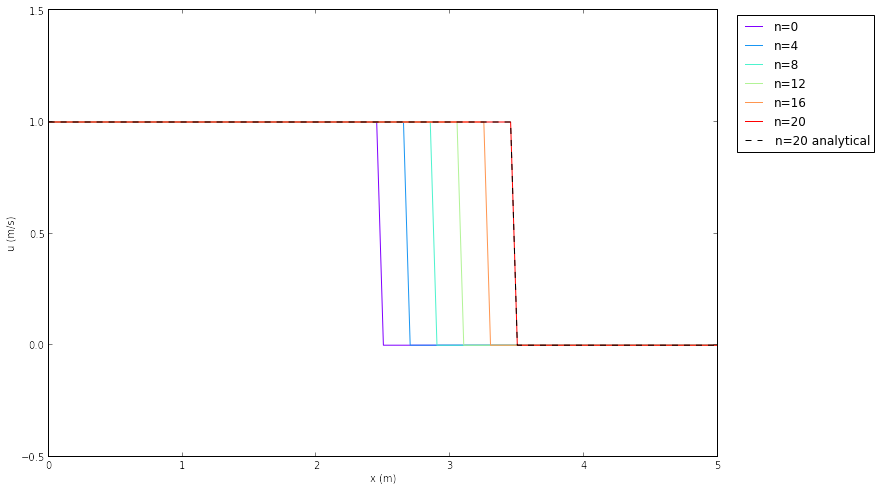

In [148]:
plot(u0,x0,nt0, u00, x00,nt00)

* If the value of $\sigma = 1$ then the new velocity simply equals the old velocity. 
* The phase angle is zero, so there is no diffusion or dispersion error

In [149]:
u11, x11, nt11 = analytical(0.5, 101, 1.0, 5.0, 1.0)

In [150]:
u1, x1, nt1 = upwind_convection(0.5, 101, 1.0, 5.0, 1.0)

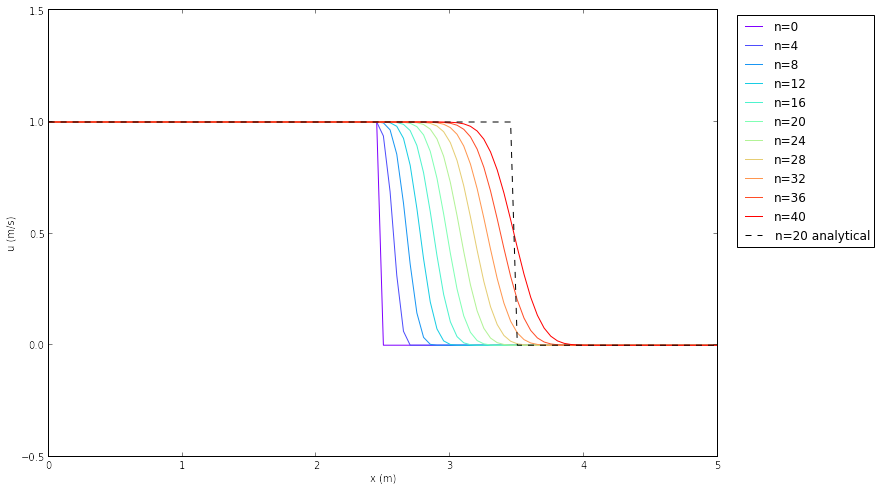

In [151]:
plot(u1,x1,nt1,u11,x11,nt11)

* The jump is diffused by the numerical diffusion arising from the first order truncation error
* The amount of diffusion is increasing as we move through time (as n increases)
* The numerical speed with which the solution moves through the domain is also reduced

In [152]:
u22, x22, nt22 = analytical(0.25, 101, 1.0, 5.0, 1.0)

In [153]:
u2, x2, nt2 = upwind_convection(0.25, 101, 1.0, 5.0, 1.0)

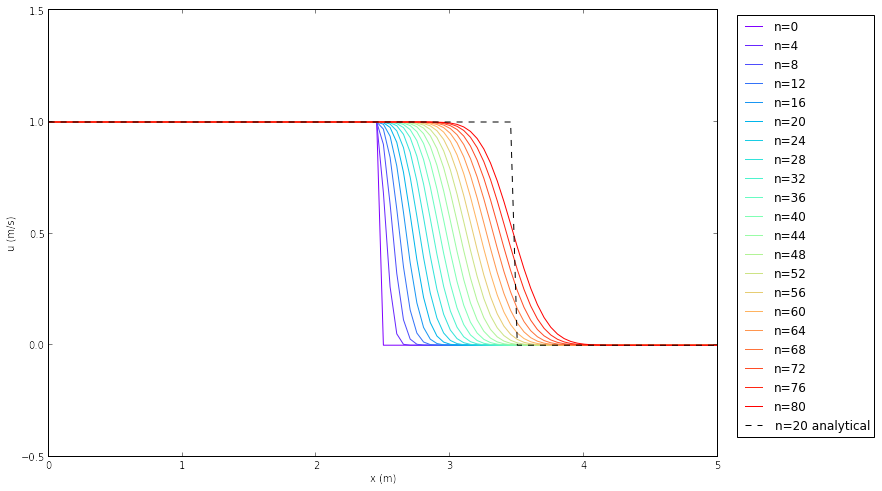

In [154]:
plot(u2,x2,nt2,u22, x22, nt22)

* Clearly, the smaller Courant Number reduces the speed at which the solution travels through the domain
* At these very low frequencies, there is not much more added diffusion between $\sigma = 0.50$ and $\sigma = 0.25$

# Design Algorithm to Solve Problem using Leapfrog Scheme

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* n $\rightarrow$ index of time

## Lax Friedrichs scheme

* For the **one** first derivative of velocity in time: 2nd order CD in time
* For the **one** first derivative of velocity in space: 2nd order CD in space

* Use upwind to initialise the leapfrog scheme

## Discrete equation

$$  {{u_i^{n+1} - u_i^{n-1}} \over {2 \Delta t}} + c {{u_{i-1}^n - u_{i-1}^n} \over {2 \Delta x}}=0 $$

## Transpose

$$ u_i^{n+1} = u_i^{n-1} - {{c \Delta t} \over \Delta x} (u_{i+1}^n - u_{i-1}^n)  $$

## Pseudo-code

       #Constants
       xmax = 4.0
       nx = 51
       dx = xmax/(nx-1)
       tmax = 1.0
       sigma = 1.0
       dt =  (dx / sigma)
       nt = int(tmax/dt + 1)
       
       #Boundary Conditions
       for n between 0 and nt
          u(0,n)=1
          u(nx-1,n)=0 

       #Initial Conditions
       for i between 1 and nx-2
          if(i < (nx-1)/2)
              u(i,0) = 1
          else
              u(i,0) = 0

       #Initialise using Upwind
       n = 0
       for i between 1 and nx-2
           u(i,n+1) = u(i,n)-c*(dt/dx)*(u(i,n)-u(i-1,n)
              
       #Proceed Using Leapfrog
       for n between 1 and nt-1
          for i between 1 and nx-2
              u(i,n+1) = u(i,n-1)-c*(dt/dx)*(u(i+1,n)-u(i-1,n)

In [126]:
def leapfrog_convection(sigma, nx, tmax, xmax, c):
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt =  ((dx * sigma) / c)
    nt = int(tmax/dt + 1)

    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)
    
    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)
    
    # Initialise using Upwind
    n = 0
    i = 1
    u[i:nx-1, n+1] = u[i:nx-1, n]-sigma*(u[i:nx-1, n]-u[i-1:nx-2, n])
    
    # Proceed using Leapfrog
    for n in range(1, nt-1):
        u[i:nx-1, n+1] = u[i:nx-1, n-1]-sigma*(u[i+1:nx, n]-u[i-1:nx-2, n])
    
    return u, x, nt

In [155]:
u44, x44, nt44 = analytical(0.5, 101, 1.0, 5.0, 1.0)

In [156]:
u4, x4, nt4 = leapfrog_convection(0.5, 101, 1.0, 5.0, 1.0)

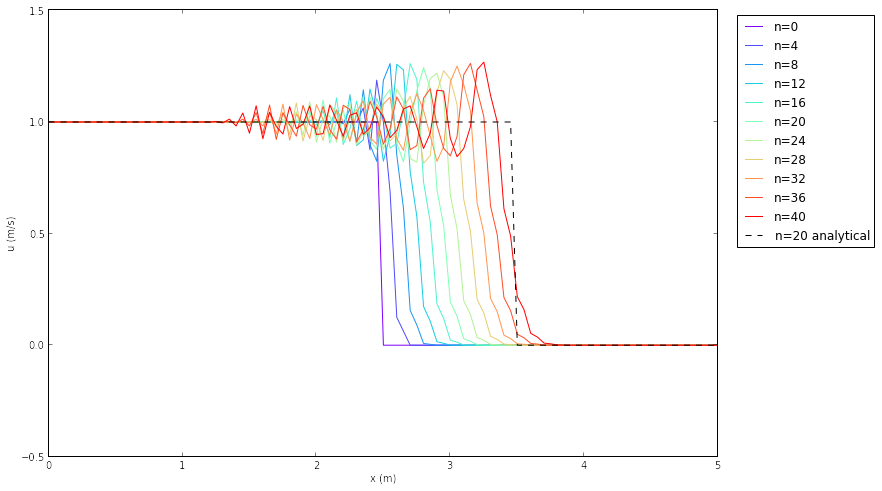

In [157]:
plot(u4,x4,nt4,u44, x44, nt44)

Oscillatory, behind the wave, more accurate than Lax-Friedrichs

# Design Algorithm to Solve Problem using Lax Friedrichs Scheme

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* n $\rightarrow$ index of time

## Lax Friedrichs scheme

$$ u_i^{n+1} = {1 \over 2} (u_{i-1}^n + u_{i+1}^n) - {\sigma \over 2}(u_{i+1}^n - u_{i-1}^n) $$

## Pseudo-code

       #Constants
       xmax = 4.0
       nx = 51
       dx = xmax/(nx-1)
       tmax = 1.0
       sigma = 1.0
       dt =  (dx / sigma)
       nt = int(tmax/dt + 1)
       
       #Boundary Conditions
       for n between 0 and nt
          u(0,n)=1
          u(nx-1,n)=0 

       #Initial Conditions
       for i between 1 and nx-2
          if(i < (nx-1)/2)
              u(i,0) = 1
          else
              u(i,0) = 0

       #Iteration
       for n between 0 and nt-1
          for i between 1 and nx-2
              u(i,n+1) = 0.5*(u(i-1,n)+u(i+1,n))-0.5*sigma*(u(i+1,n)-u(i-1,n)

In [132]:
def lax_friedrichs_convection(sigma, nx, tmax, xmax, c):
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt =  ((dx * sigma) / c)
    nt = int(tmax/dt + 1)

    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt-1):
        u[i:nx-1, n+1] = 0.5*(u[i-1:nx-2, n]+u[i+1:nx, n])-0.5*sigma*(u[i+1:nx, n]-u[i-1:nx-2, n])

    return u, x, nt

In [158]:
u55, x55, nt55 = analytical(0.5, 101, 1.0, 5.0, 1.0)

In [159]:
u5, x5, nt5 = lax_friedrichs_convection(0.5, 101, 1.0, 5.0, 1.0)

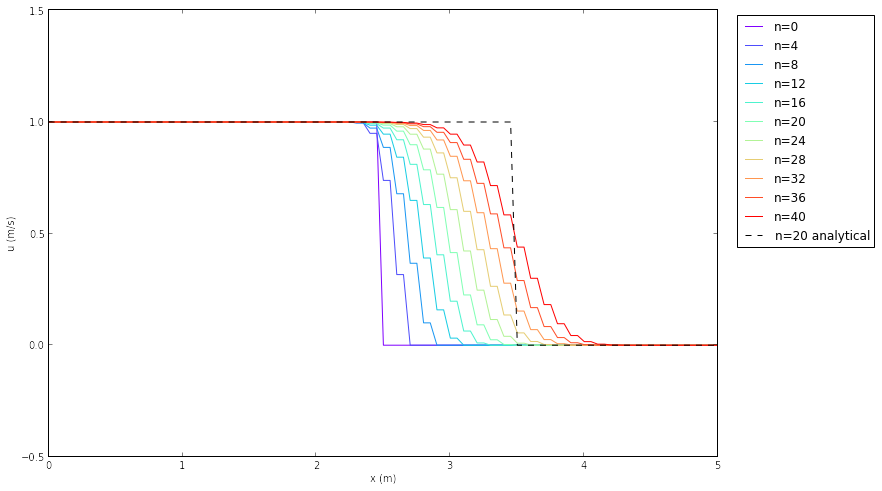

In [160]:
plot(u5,x5,nt5,u55, x55, nt55)

* Numerical dissipation and odd-even decoupling
* Amount of diffusion is still increasing with increasing n

# Design Algorithm to Solve Problem using Lax Wendroff Scheme

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* n $\rightarrow$ index of time

## Lax Wendroff scheme

$$ u_i^{n+1} = u_i^n - {\sigma \over 2}(u_{i+1}^n - u_{i-1}^n) + {\sigma^2 \over 2} (u_{i+1}^n - 2u_i^n + u_{i-1}^n) $$

In [138]:
def lax_wendroff_convection(sigma, nx, tmax, xmax, c):
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt =  ((dx * sigma) / c)
    nt = int(tmax/dt + 1)

    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt-1):
        u[i:nx-1, n+1] = (u[i:nx-1, n] - 0.5*sigma*(u[i+1:nx, n] - u[i-1:nx-2, n]) +
                         0.5*(sigma**2)*(u[i+1:nx, n] - 2.0*u[i:nx-1, n] + u[i-1:nx-2, n]))

    return u, x, nt

In [161]:
u66, x66, nt66 = analytical(0.5, 101, 1.0, 5.0, 1.0)

In [162]:
u6, x6, nt6 = lax_wendroff_convection(0.5, 101, 1.0, 5.0, 1.0)

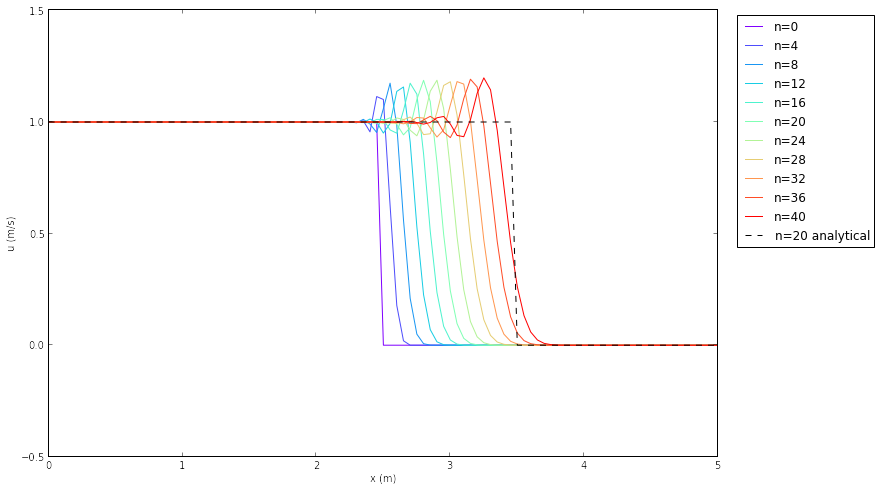

In [163]:
plot(u6,x6,nt6,u66, x66, nt66)

* This more accurately represents the step change
* However, there is an oscillatory response